In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

## Engagement Data ##

In [10]:
raw_engagement_df = pd.read_csv('takehome_user_engagement.csv')
raw_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [85]:
len(raw_engagement_df['user_id'].unique())

8823

In [12]:
raw_engagement_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [28]:
raw_engagement_df.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

### Observations ###
No missing data, but the timestamp data is in object type instead of datetime type. I also don't need time, just date. And I need to reorder the data.

In [57]:
engagement_df = (raw_engagement_df
                 .assign(timestamp = lambda x: pd.to_datetime(x['time_stamp']).dt.floor('1D'))
                 .drop('time_stamp', axis = 1)
                 .reindex(columns = ['timestamp', 'user_id', 'visited'])
                 .sort_values(by='timestamp')
                 .reset_index(drop = True)
                )

In [50]:
engagement_df.head()

,timestamp,user_id,visited
0,2012-05-31,1693,1
1,2012-05-31,3428,1
2,2012-05-31,10012,1
3,2012-05-31,9899,1
4,2012-06-01,10163,1


I'll need to create a sliding window function that looks at 7 day windows to create a set of "active" users.

In [65]:
def check_adoption(df):
    return df['timestamp'].rolling(7, min_periods = 3).count() >= 3

# Group by 'user_id' and apply the function
engagement_df['visit_within_week'] = engagement_df.groupby('user_id').apply(check_adoption).reset_index(level = 0, drop = True)

# Filter users who visited at least 3 times in a 7-day period
adopted_users = engagement_df[engagement_df['visit_within_week']].reset_index()['user_id'].unique()

len(active_users)

2248

In [87]:
print(f'{2248/8823:.4f}')

0.2548


Of the 8823 users in the table, 2248 have adopted the service according to the criterion of having logged in at least 3 times in any seven-day window. This is a ~25% conversion rate.

## Users Data ##

In [9]:
raw_users_df = pd.read_csv('takehome_users.csv', encoding = 'cp1252')
raw_users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [73]:
raw_users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [69]:
raw_users_df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [70]:
raw_users_df['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [81]:
pd.to_datetime(raw_users_df['last_session_creation_time'])

0       1970-01-01 00:00:01.398138810
1       1970-01-01 00:00:01.396237504
2       1970-01-01 00:00:01.363734892
3       1970-01-01 00:00:01.369210168
4       1970-01-01 00:00:01.358849660
                     ...             
11995   1970-01-01 00:00:01.378448055
11996   1970-01-01 00:00:01.358274517
11997   1970-01-01 00:00:01.398602716
11998   1970-01-01 00:00:01.338638159
11999   1970-01-01 00:00:01.390726632
Name: last_session_creation_time, Length: 12000, dtype: datetime64[ns]

### Observations ###
This table needs more attention.
* The time data is not of consistent format.
*  I have missing values in the last session column and the invited-by-user-id column.
    *  These both make sense. If the user wasn't invited by another, they won't have a user id attributed to an inviter.
    *  If the user never logged in after creating their account, they won't have a last session creation time. 
    * I'll fill the missing values in the session creation column with the signup date. I'll investigate the intviter user id column to understand if I can drop that column. Unless there are certain users that invite hundreds of users, this information probably isn't helpful for predictive or therefore actionable purposes. It'll more or less be captured by the creation source column.
* I have names and emails that won't be useful for predictions, so I can drop those

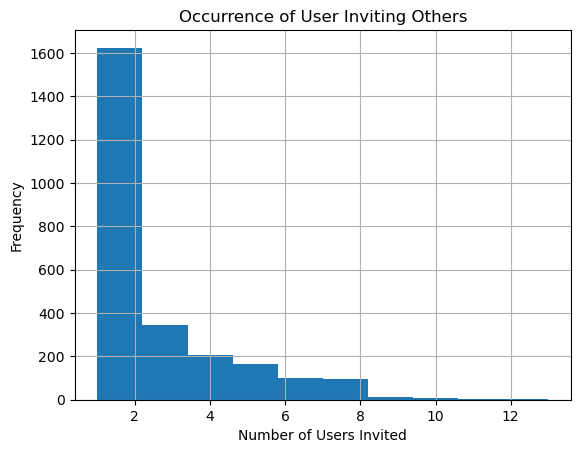

In [77]:
raw_users_df['invited_by_user_id'].value_counts().hist()
plt.title('Occurrence of User Inviting Others')
plt.ylabel('Frequency')
plt.xlabel('Number of Users Invited')
plt.show()

Most users who invite others only invite 1 other user. I can drop the column of inviter ID's without affecting my ability to analyze and predict from the remaining data.

In [ ]:
users_df = (raw_users_df
            .drop(['invited_by_user_id', 'name', 'email'], axis = 1)
            .fillna(raw_users_df['creation_time'])
            .assign(creation_date = lambda x: pd.to_datetime(x['creation_time']).dt.floor('1D'))
            .assign(last_session = lambda x: pd.to_datetime(x['last_session_creation_time'], unit='s').dt.floor('1D'))
            .assign(adopted = lambda x: x['object_id'].isin(active_users))
            .astype({'adopted': 'int'})
            .drop(['creation_time', 'last_session_creation_time'], axis = 1)
            .pipe(lambda df: pd.get_dummies(df, columns = ['creation_source'], drop_first = False))
            .rename(columns = {
                'object_id': 'user_id',
                'opted_in_to_mailing_list': 'mail_list', 
                'enabled_for_marketing_drip': 'drip_mktg', 
                'creation_source_ORG_INVITE': 'org_invite',
                'creation_source_PERSONAL_PROJECTS': 'project_signup',
                'creation_source_SIGNUP': 'signup',
                'creation_source_SIGNUP_GOOGLE_AUTH': 'google_signup',
                'creation_source_GUEST_INVITE': 'guest_invite'
            })
            .reindex(columns = [
                'user_id',
                'mail_list',
                'drip_mktg', 
                'org_id', 
                'org_invite', 
                'project_signup', 
                'signup', 
                'google_signup', 
                'guest_invite', 
                'creation_date', 
                'last_session', 
                'adopted'
            ])
           )
users_df.head()

,user_id,mail_list,drip_mktg,org_id,org_invite,project_signup,signup,google_signup,guest_invite,creation_date,last_session,adopted
0,1,1,0,11,0,0,0,0,1,2014-04-22,2014-04-22,0
1,2,0,0,1,1,0,0,0,0,2013-11-15,2014-03-31,1
2,3,0,0,94,1,0,0,0,0,2013-03-19,2013-03-19,0
3,4,0,0,1,0,0,0,0,1,2013-05-21,2013-05-22,0
4,5,0,0,193,0,0,0,0,1,2013-01-17,2013-01-22,0
